# Titanic

James Perryman

Here we will take a trip on the Titanic using the kaggle data set: https://www.kaggle.com/c/titanic/data. We will look for all of the relevant charateristics of each passenger and try to see what factors contribute to an individual surviving.  This workbook will include data cleaning, data exploration, and model fitting.

In [1]:
#Let's find out who survived
from IPython.display import Image
Image(url= "https://upload.wikimedia.org/wikipedia/commons/6/6e/St%C3%B6wer_Titanic.jpg")

# Data Cleaning

I will start by importing packages and the data

In [2]:
# Core Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
%matplotlib inline

# ML Packages
from sklearn.linear_model import SGDRegressor, ElasticNetCV, LogisticRegression
from sklearn.metrics import mean_squared_error, make_scorer, f1_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Missingno Package
import missingno as msno

In [3]:
#import data
train_location = "/Users/jperryman/Desktop/BYU/Python/HW3/train.csv"
test_location = "/Users/jperryman/Desktop/BYU/Python/HW3/test.csv"

train = pd.read_csv(train_location)
test = pd.read_csv(test_location)


In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.sum()

PassengerId                                               397386
Survived                                                     342
Pclass                                                      2057
Name           Braund, Mr. Owen HarrisCumings, Mrs. John Brad...
Sex            malefemalefemalefemalemalemalemalemalefemalefe...
Age                                                      21205.2
SibSp                                                        466
Parch                                                        340
Ticket         A/5 21171PC 17599STON/O2. 31012821138033734503...
Fare                                                     28693.9
dtype: object

Alright, now that I have the data I need to check for missing values

In [6]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

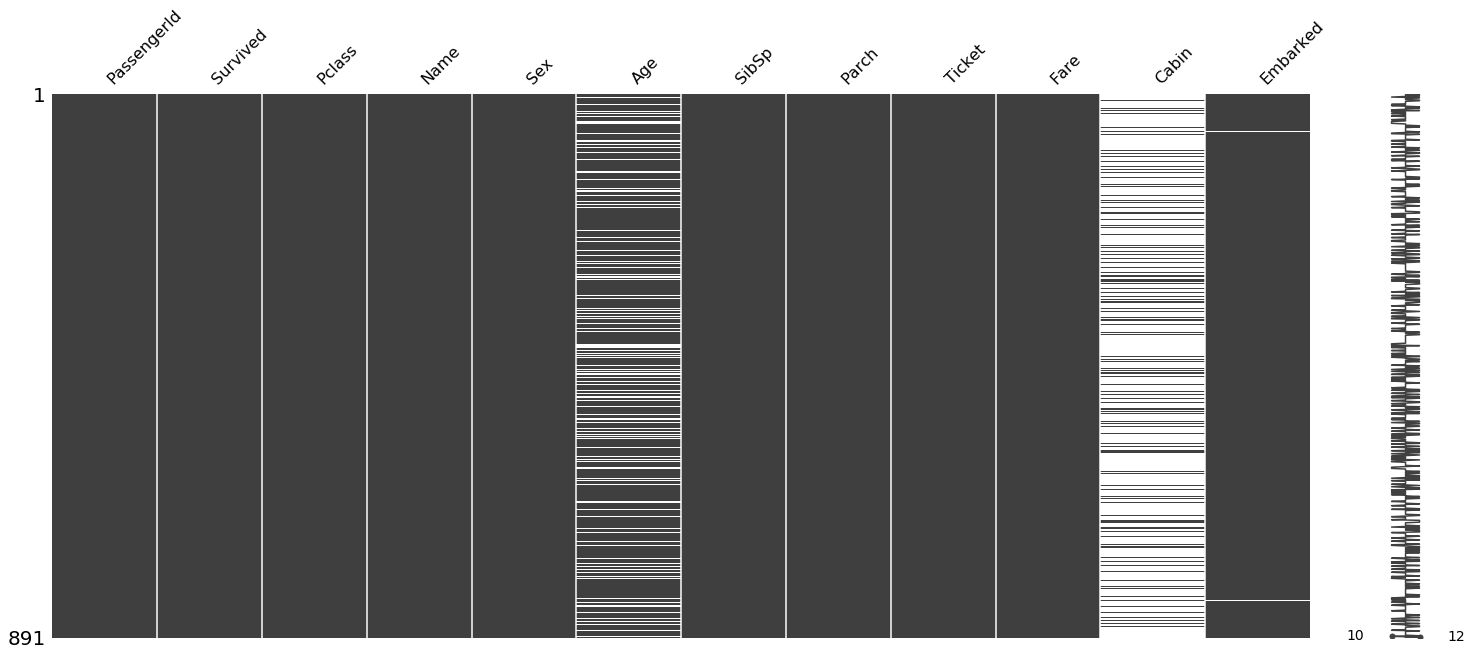

In [7]:
msno.matrix(train)

OK, there are a lot of missing values, but that should not be too much of a problem..

In [8]:
# Seperate rows that contain missing values from those that dn't
missing = train[pd.isnull(train).any(axis=1)]
not_missing = train[pd.notnull(train).any(axis=1)]

In [9]:
# Create a 'difference' correlation matrix
diff = missing.corr() - not_missing.corr()

Here I drop certain columns and create new variables that I believe will be important.

In [11]:
# Drop the PassengerID', 'Name', and 'Ticket' features
train = train.drop(['PassengerId', 'Name', 'Ticket',], axis = 1)

In [12]:
#Create binary Cabin variable
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
train = train.drop(['Cabin'], axis = 1)

In [13]:
# Fill in the missing values of Age with the mean
train['Age'] = train['Age'].fillna(train['Age'].mean())

# Fill in two missing values of Embarked with the mode
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])

In [14]:
# Should return 'False'
train.isnull().any().any()

False

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Sex          891 non-null object
Age          891 non-null float64
SibSp        891 non-null int64
Parch        891 non-null int64
Fare         891 non-null float64
Embarked     891 non-null object
Has_Cabin    891 non-null int64
dtypes: float64(2), int64(5), object(2)
memory usage: 62.7+ KB


# Data Vizualization

First I will start by comparing all of the variable to each other to see if their is serial correlation or a redundant variable.

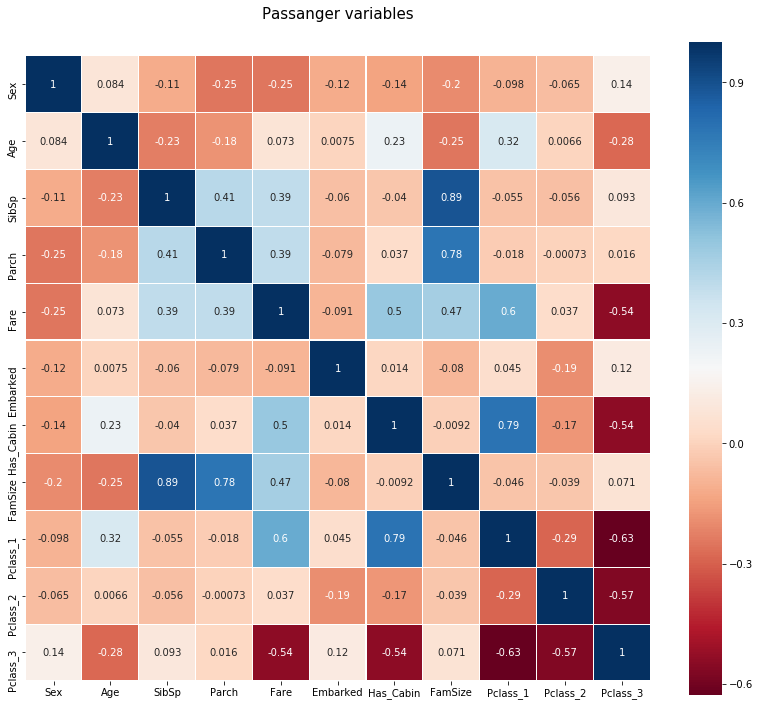

In [68]:
#colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Passanger variables', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
           square=True, cmap=colormap, linecolor='white', annot=True)

Now I want to look at who survived and what the passangers on the ship were like.

Text(0.5,1,'Distribution of Survival, (1 = Survived)')

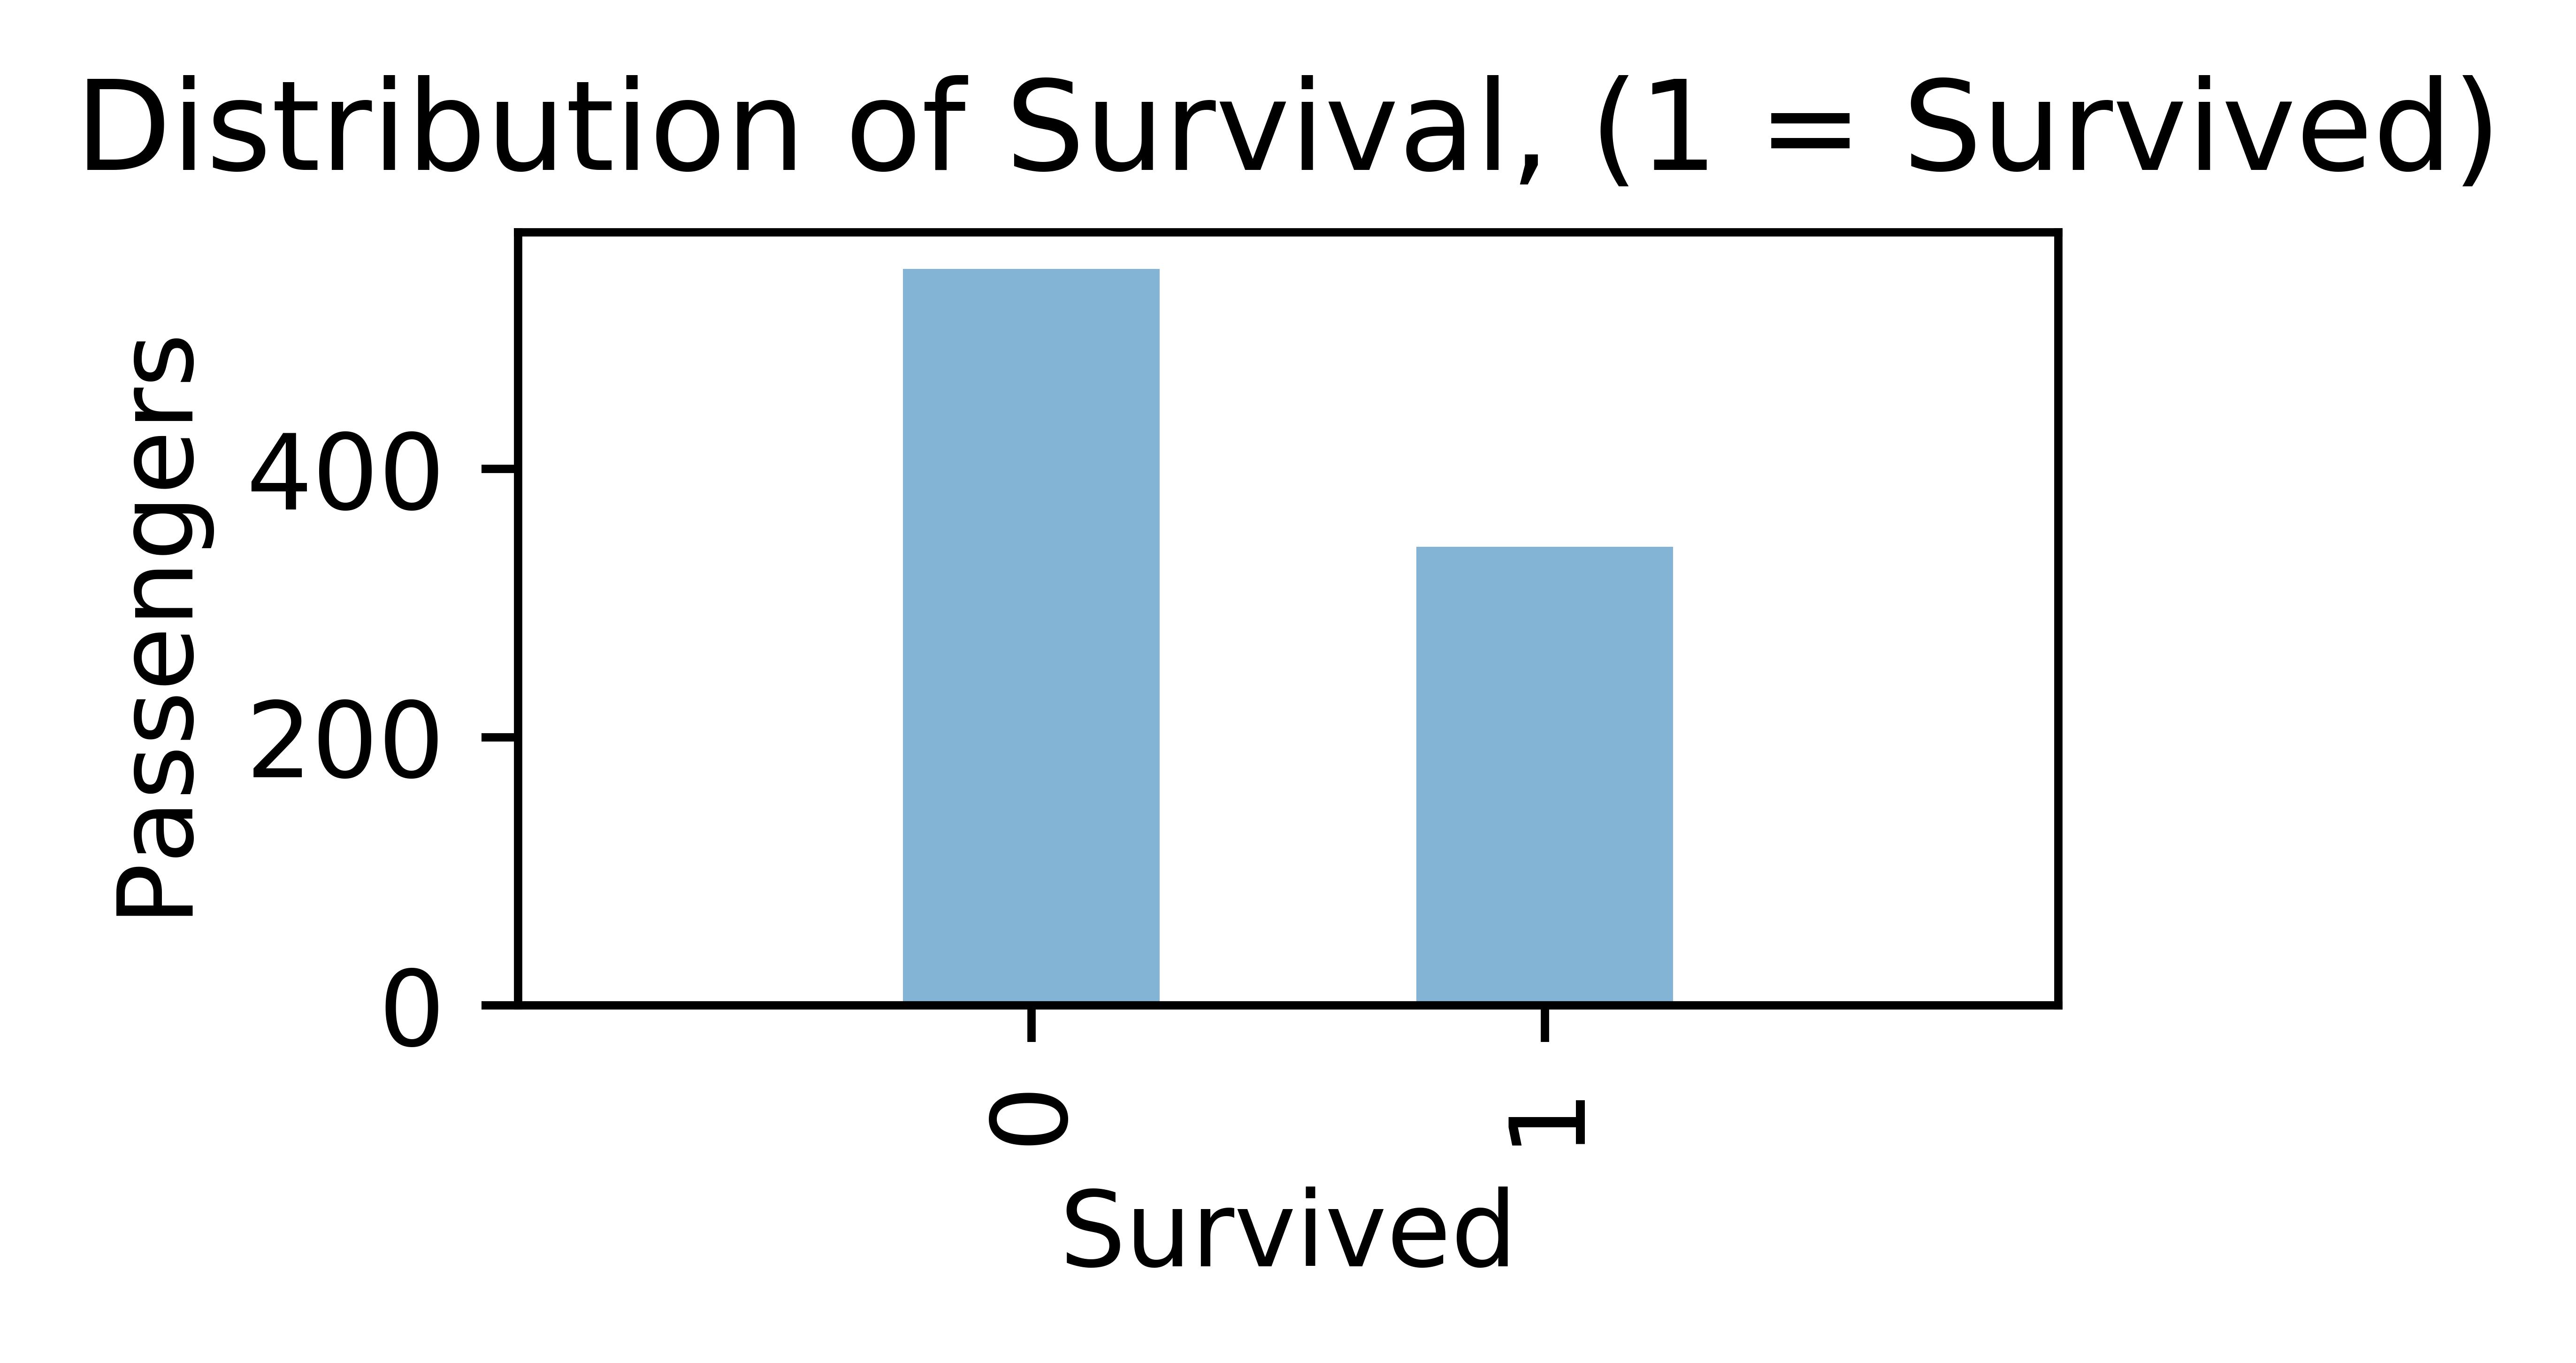

In [16]:
fig = plt.figure(figsize=(9,3), dpi=1600) 
alpha_bar_chart = 0.55
# lets us plot many diffrent shaped graphs together 
ax1 = plt.subplot2grid((2,3),(0,0))
# plots a bar graph of those who surived vs those who did not.               
train.Survived.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
# this nicely sets the margins in matplotlib to deal with a recent bug 1.3.1
ax1.set_xlim(-1, 2)
# puts a title on our graph
plt.ylabel("Passengers")
plt.xlabel("Survived")
plt.title("Distribution of Survival, (1 = Survived)")

Text(0.5,1,'Class Distribution')

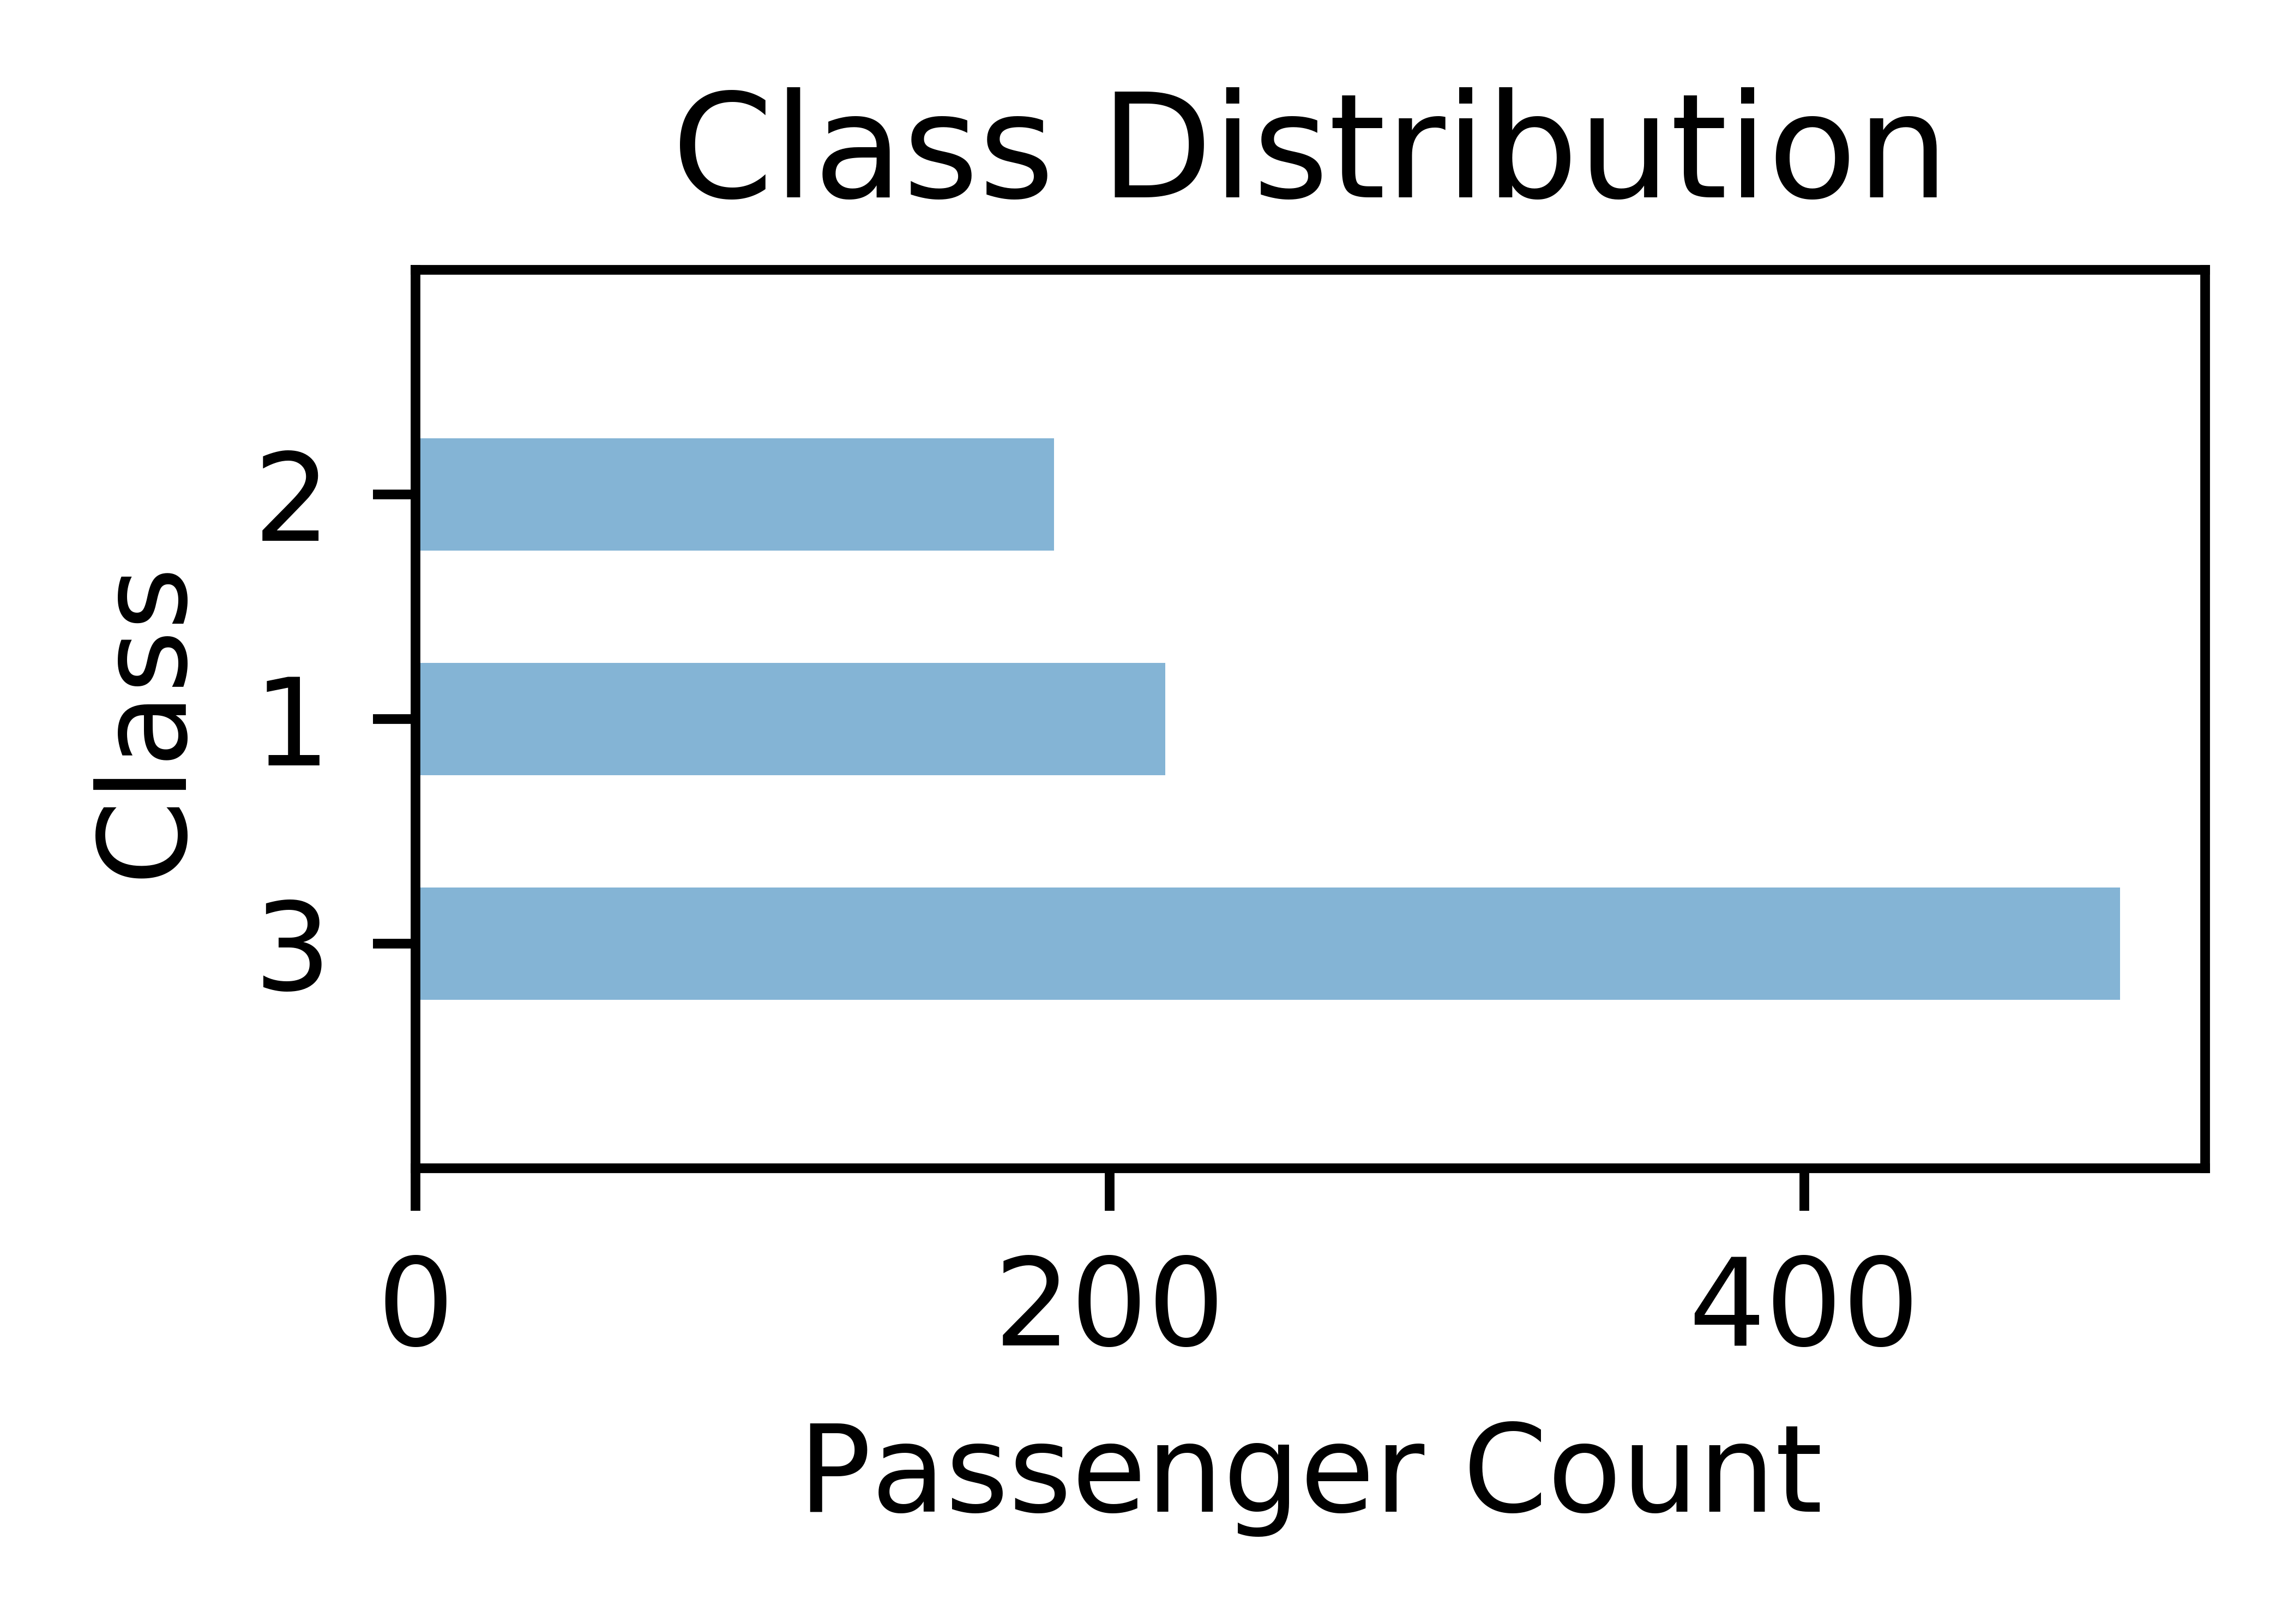

In [17]:
fig = plt.figure(figsize=(9,3), dpi=1600) 
alpha_bar_chart = 0.55
ax3 = plt.subplot2grid((2,3),(0,2))
train.Pclass.value_counts().plot(kind="barh", alpha=alpha_bar_chart)
ax3.set_ylim(-1, len(train.Pclass.value_counts()))
plt.xlabel('Passenger Count')
plt.ylabel('Class')
plt.title("Class Distribution")

In [19]:
fig = plt.figure(figsize=(18,6), dpi=1600) 
plt.subplot2grid((2,3),(1,0), colspan=2)
# plots a kernel density estimate of the subset of the 1st class passangers's age
train.Age[train.Pclass == 1].plot(kind='kde')    
train.Age[train.Pclass == 2].plot(kind='kde')
train.Age[train.Pclass == 3].plot(kind='kde')
 # plots an axis lable
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
# sets our legend for our graph.
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') 

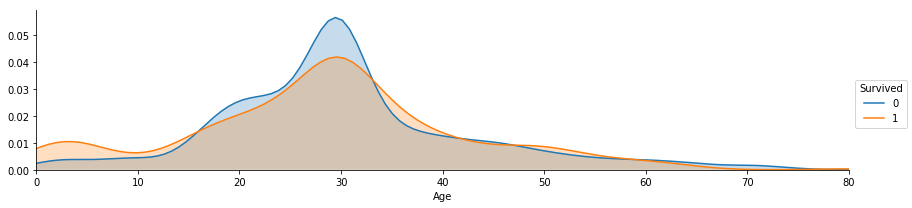

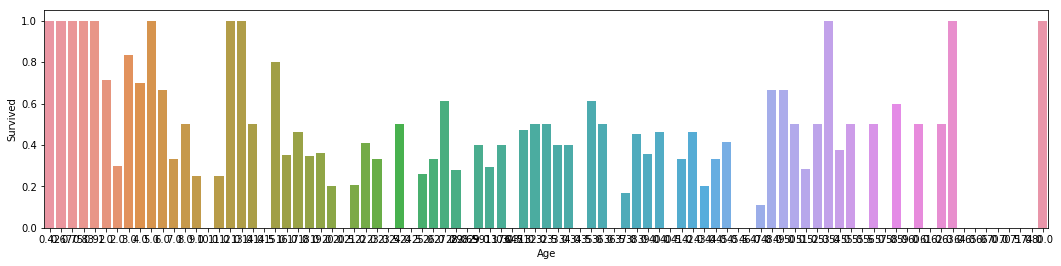

In [20]:
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

# average survived passengers by age
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = train[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

This is my favorite graph.  It does a good job showing the population of the sample while also giving information as to if the majority survived or not.  I wonder how many passangers total survived.

In [24]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [25]:
print(round(342/(549+342),2)*100, "% of the passengers in the dataset survived.")

38.0 % of the passengers in the dataset survived.


Text(0.5,1,'Passengers per boarding location')

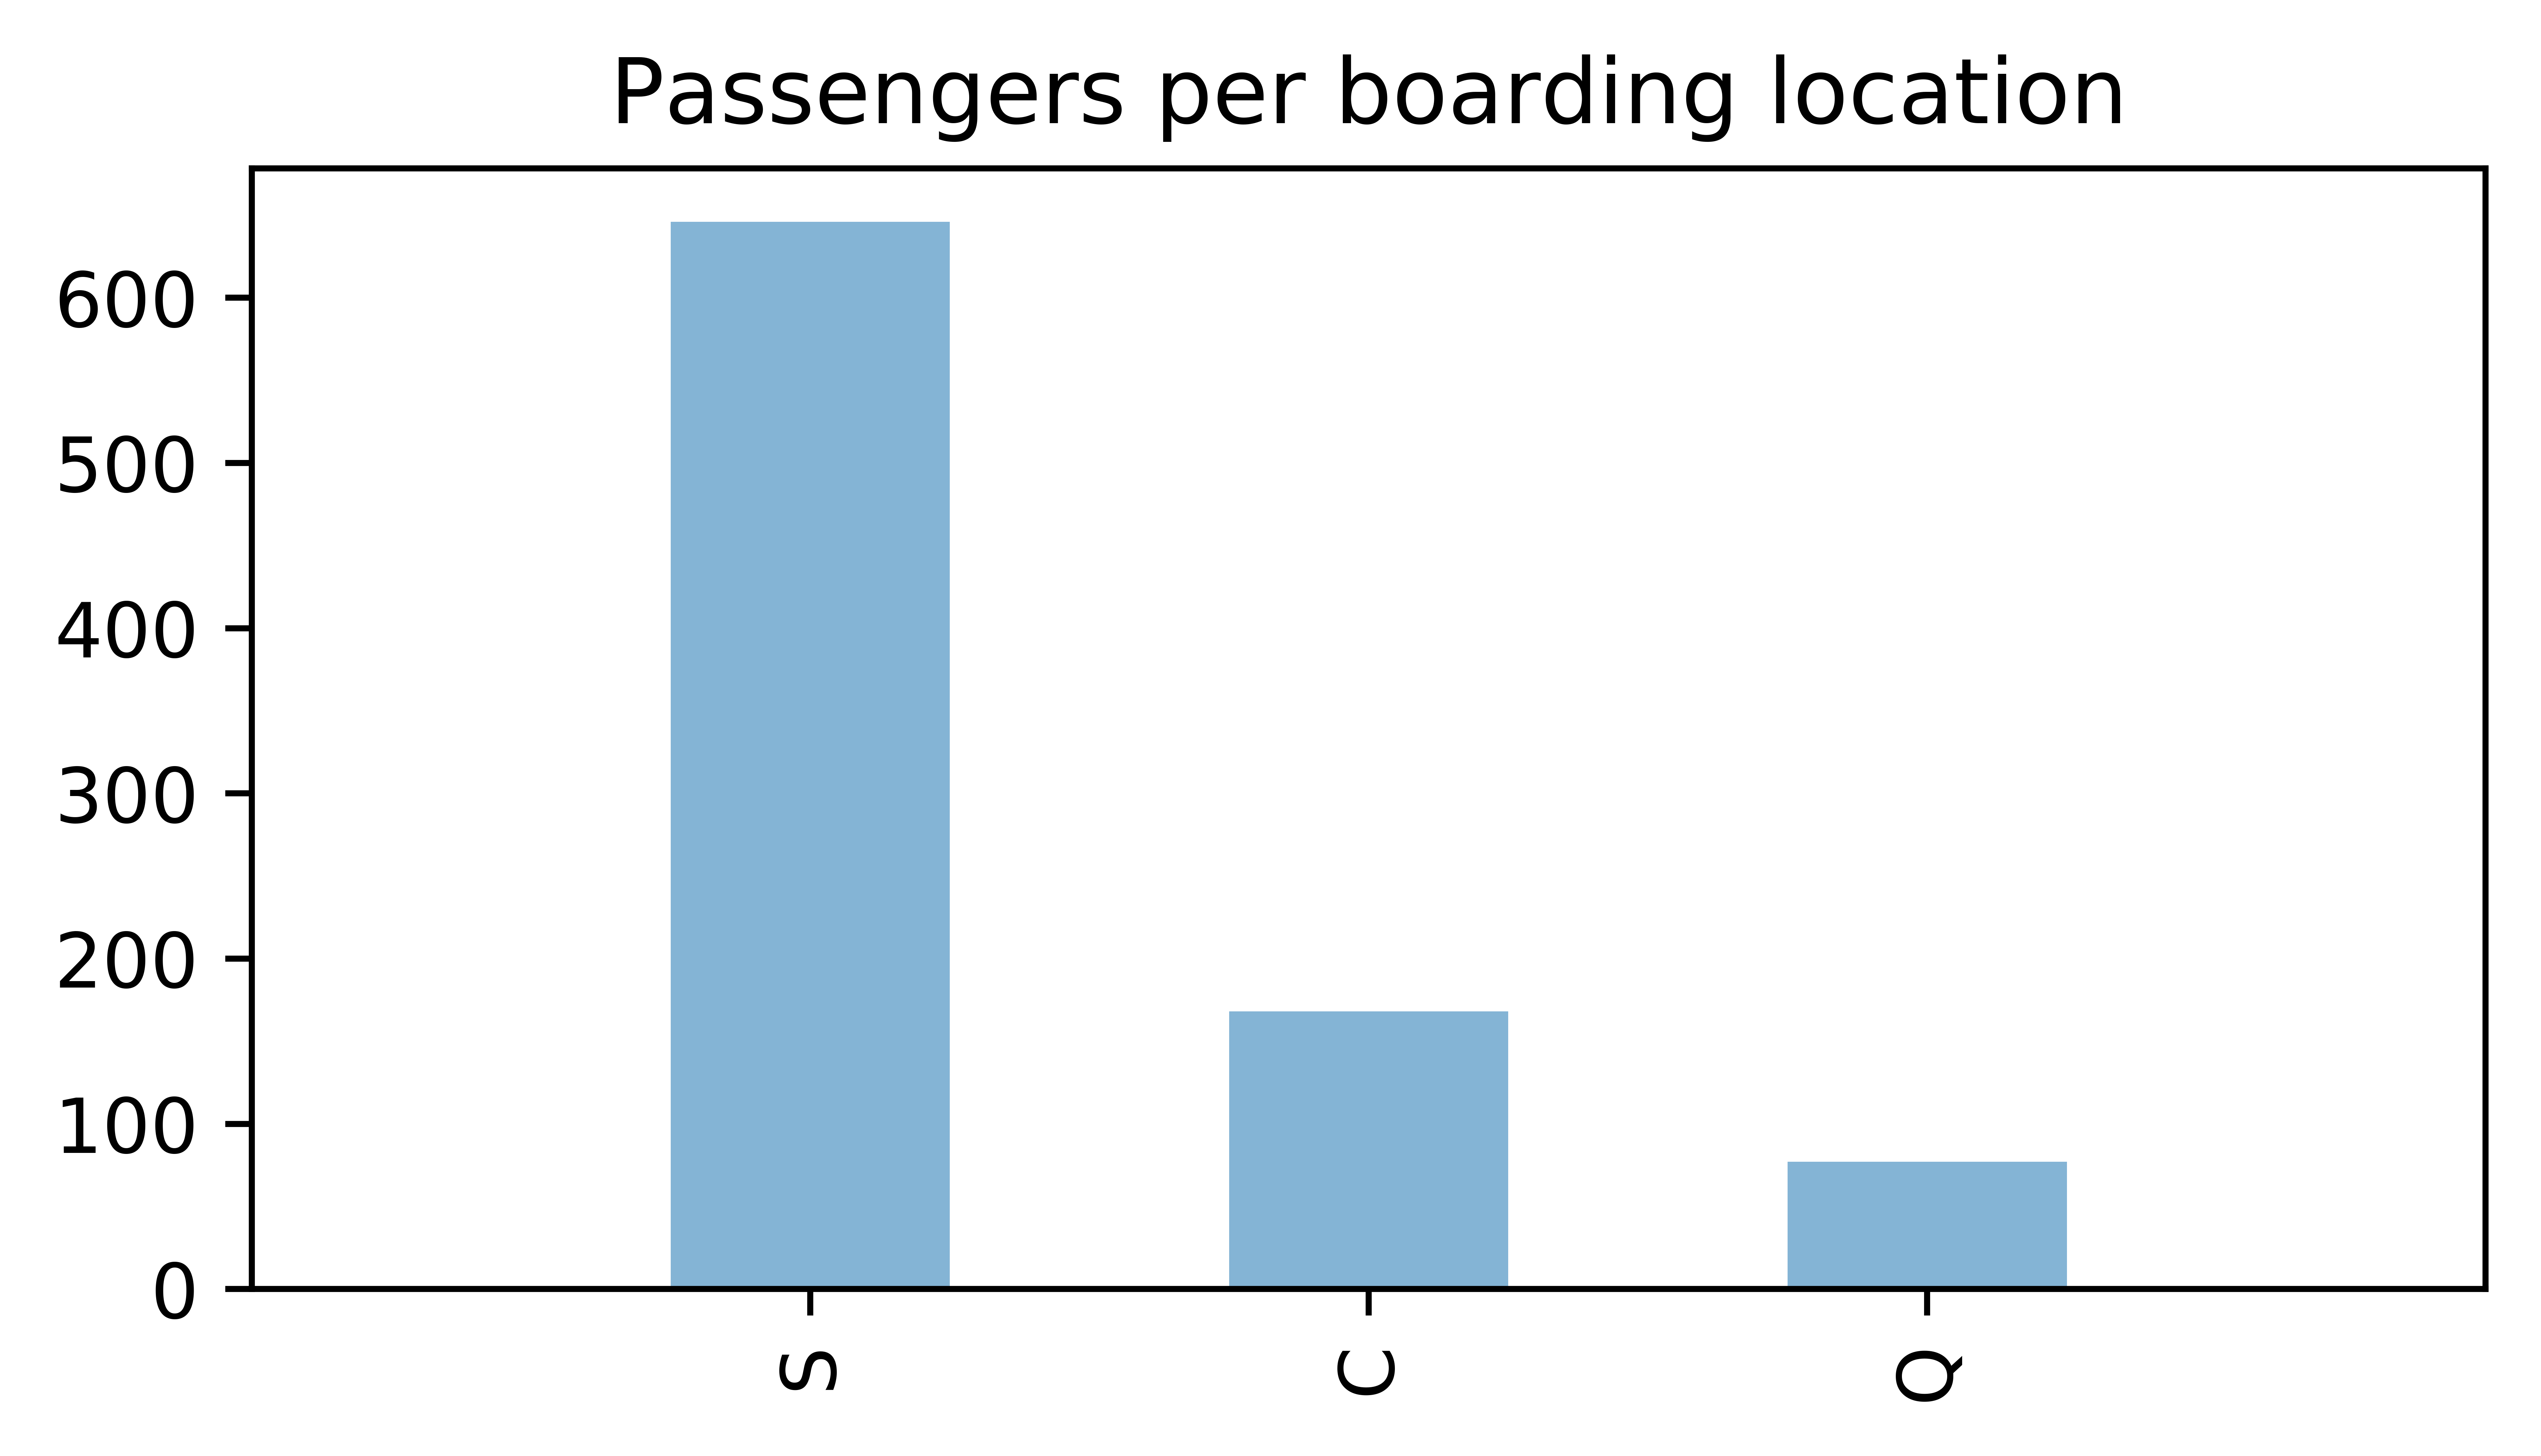

In [21]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,6), dpi=1600) 
alpha_bar_chart = 0.55


ax5 = plt.subplot2grid((2,3),(1,2))
train.Embarked.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
ax5.set_xlim(-1, len(train.Embarked.value_counts()))
# specifies the parameters of our graphs
plt.title("Passengers per boarding location")

In [22]:
train['Survived'] = train['Survived'].astype('category')
train['Pclass'] = train['Pclass'].astype('category')

In [23]:
# Feature engineer a 'FamSize' variable
train['FamSize'] = train['SibSp'] + train['Parch']

In [26]:
# Cross tab is an way to get a frequency tables
pd.crosstab(train['Survived'], train.Pclass)

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


I want to change all of my data to whole numbers to analyze them better.  I will change certain categorical data to numerical data.

In [27]:
# Mapping Embarked
train['Embarked'] = train['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [28]:
# Mapping Sex
train['Sex'] = train['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [29]:
 # Mapping Fare
train.loc[ train['Fare'] <= 7.91, 'Fare']  = 0
train.loc[(train['Fare'] > 7.91) & (train['Fare'] <= 14.454), 'Fare'] = 1
train.loc[(train['Fare'] > 14.454) & (train['Fare'] <= 31), 'Fare']   = 2
train.loc[ train['Fare'] > 31, 'Fare']    = 3
train['Fare'] = train['Fare'].astype(int)

In [31]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has_Cabin,FamSize
0,0,3,1,22.0,1,0,0,0,0,1
1,1,1,0,38.0,1,0,3,1,1,1
2,1,3,0,26.0,0,0,1,0,0,0
3,1,1,0,35.0,1,0,3,0,1,1
4,0,3,1,35.0,0,0,1,0,0,0


Awesome! Now all of my data is intergers and not string data.  Now I can do more analysis of important variables.

Text(0.5,1,'Survived: Male vs. Female')

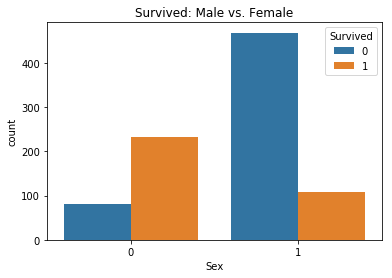

In [32]:
ax = sns.countplot('Sex', hue='Survived',data = train)
ax.set_title('Survived: Male vs. Female')

Text(0.5,1,'Survived: No Cabin vs. Cabin')

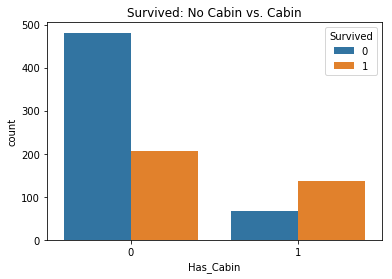

In [33]:
ax = sns.countplot('Has_Cabin', hue='Survived',data = train)
ax.set_title('Survived: No Cabin vs. Cabin')

In [36]:
train['FamSize'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: FamSize, dtype: int64

Text(0.5,1,'Survived: Family Size')

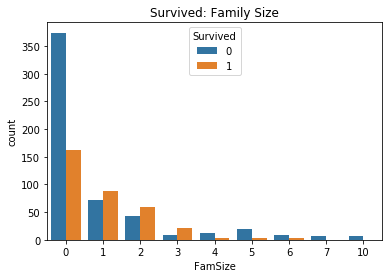

In [37]:
ax = sns.countplot('FamSize', hue='Survived',data = train)
ax.set_title('Survived: Family Size')

In [38]:
train['Embarked'].value_counts()

0    646
1    168
2     77
Name: Embarked, dtype: int64

Text(0.5,1,'Survived: Family Size')

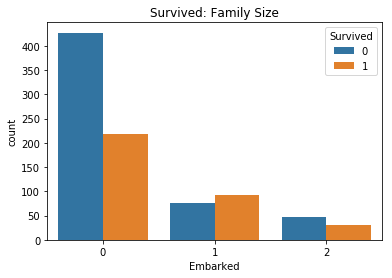

In [39]:
ax = sns.countplot('Embarked', hue='Survived',data = train)
ax.set_title('Survived: Family Size')

Surprisingly it looks like the embarkation correlated if a passanger survived.

# Model

In [40]:
#Create a 'target' variable and drop 'Survived' from the training set
target = train['Survived']
train = train.drop(['Survived'], axis = 1)

In [41]:
#Apply the same transformation made to our training set to our test set

# Fill in the missing values of Age with the mean
test['Age'] = test['Age'].fillna(train['Age'].mean())

#Fill in variable for Cabin
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Fill in two missing values of Embarked with the mode
test['Embarked'] = test['Embarked'].fillna(train['Embarked'].mode()[0])

# Drop the 'Cabin', 'PassengerID', 'Name', and 'Ticket' features
test = test.drop(['Cabin', 'PassengerId', 'Name', 'Ticket'], axis = 1)

# Fill in the one missing value of Fare with the mean
test['Fare'] = test['Fare'].fillna(train['Fare'].mean())

test['Pclass'] = test['Pclass'].astype('category')
test['FamSize'] = test['SibSp'] + test['Parch']

# Duplicate for test data
test['Embarked'] = test['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

# Duplicate for test data
test['Sex'] = test['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

#Duplicate for test data
test.loc[ test['Fare'] <= 7.91, 'Fare']  = 0
test.loc[(test['Fare'] > 7.91) & (train['Fare'] <= 14.454), 'Fare'] = 1
test.loc[(test['Fare'] > 14.454) & (train['Fare'] <= 31), 'Fare']   = 2
test.loc[ test['Fare'] > 31, 'Fare']    = 3
test['Fare'] = test['Fare'].astype(int)

In [42]:
#Create dummy variables
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [43]:
#Scale the data
scaler = StandardScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)

scaler.fit(test)
scaled_test = scaler.transform(test)

In [44]:
print("Train Dimensions:", scaled_train.shape, "\nTest Dimensions:", scaled_test.shape)

Train Dimensions: (891, 11) 
Test Dimensions: (418, 11)


In [45]:
# Split training dataset into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(scaled_train, target, test_size=0.2, random_state=42)

In [46]:
def evaluation_metrics(y_train, y_test, train_predictions, test_predictions):
    rounding = 2
    print('Accuracy:')
    print("  Train: {}".format(round(accuracy_score(y_train, train_predictions),rounding)), "  Test: {}".format(round(accuracy_score(y_test, test_predictions),rounding)))

    print('Precision:')
    print("  Train: {}".format(round(precision_recall_fscore_support(y_train, train_predictions)[0][0],rounding)), "  Test: {}".format(round(precision_recall_fscore_support(y_test, test_predictions)[0][0],rounding)))

In [47]:
def precision_recall_curves(model, X, Y):
    train_prediction_probabilities = model.predict_proba(X)
    train_probs_for_actual_1 = [train_prediction_probabilities[i][1] for i, truth in enumerate(Y) if truth == 1]
    train_probs_for_actual_0 = [train_prediction_probabilities[i][1] for i, truth in enumerate(Y) if truth == 0]
    plt.hist(train_probs_for_actual_1, label='1')
    plt.hist(train_probs_for_actual_0, label='0')
    plt.legend(loc='upper left')
    plt.title("Precision Recall Curve")
    plt.xlabel("Probability")

I like all of my data and now I believe I am ready to use different models.  I will use logistic regression, nearest neighbors, Bayes, SVM, and random forest.

Logistic regression

In [48]:
# Fit a model with the default penalty, l2
lr = linear_model.LogisticRegression(penalty='l2')
lr.fit(X_train, y_train)
lr_train_predictions = lr.predict(X_train)
lr_test_predictions = lr.predict(X_test)

In [49]:
evaluation_metrics(y_train, y_test, lr_train_predictions, lr_test_predictions)

Accuracy:
  Train: 0.81   Test: 0.8
Precision:
  Train: 0.83   Test: 0.82


Text(0.5,1,'Coefficients: Logistic Classifier')

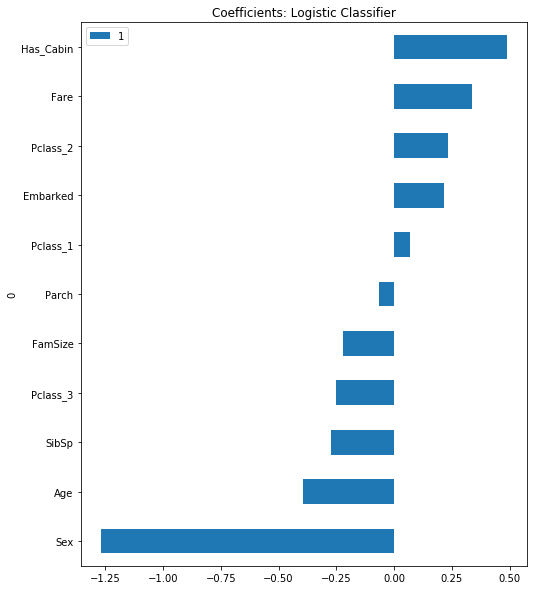

In [51]:
# Create a dataframe with coefficient values
df = pd.DataFrame(sorted(list(zip(train.columns, lr.coef_[0])), key=lambda x: x[1]))
df.index = df[0]
df = df.drop([0], axis = 1)

# Create a bar chart with the coefficients
plt.rcParams['figure.figsize'] = (8.0, 10.0)
df.plot(kind = "barh")
plt.title("Coefficients: Logistic Classifier")

Nearest Neighbors

In [52]:
param_dist = {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 'p': [1, 2, 3]}
model = KNeighborsClassifier()
knn = GridSearchCV(model, param_grid = param_dist, scoring='f1')
knn.fit(X_train, y_train)
knn_train_predictions = knn.predict(X_train)
knn_test_predictions = knn.predict(X_test)

In [53]:
evaluation_metrics(y_train, y_test, knn_train_predictions, knn_test_predictions)

Accuracy:
  Train: 0.96   Test: 0.82
Precision:
  Train: 0.94   Test: 0.82


Naive Bayes

In [54]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_train_predictions = nb.predict(X_train)
nb_test_predictions = nb.predict(X_test)

In [55]:
evaluation_metrics(y_train, y_test, nb_train_predictions, nb_test_predictions)

Accuracy:
  Train: 0.77   Test: 0.78
Precision:
  Train: 0.84   Test: 0.87


SVM

In [56]:
param_dist = {"C": [0.2, 0.5, 0.7], "kernel": ['linear', 'poly', 'rbf'], 'degree': [1,2,3]}
model = SVC()
svm = GridSearchCV(model, param_grid = param_dist, scoring='f1')
svm.fit(X_train, y_train)
svm_train_predictions = svm.predict(X_train)
svm_test_predictions = svm.predict(X_test)
print("Best Params: {}".format(svm.best_params_))

Best Params: {'C': 0.7, 'degree': 1, 'kernel': 'rbf'}


In [57]:
evaluation_metrics(y_train, y_test, svm_train_predictions, svm_test_predictions)

Accuracy:
  Train: 0.84   Test: 0.82
Precision:
  Train: 0.82   Test: 0.81


Decision Tree

In [58]:
# Model with CLEAENED data
param_dist = {"criterion": ['gini', 'entropy']}
model = DecisionTreeClassifier()
dt = GridSearchCV(model, param_grid = param_dist, scoring='f1')
dt.fit(X_train, y_train)
dt_train_predictions = dt.predict(X_train)
dt_test_predictions = dt.predict(X_test)
print("Best Params: {}".format(dt.best_params_))

Best Params: {'criterion': 'entropy'}


In [59]:
evaluation_metrics(y_train, y_test, dt_train_predictions, dt_test_predictions)

Accuracy:
  Train: 0.96   Test: 0.82
Precision:
  Train: 0.94   Test: 0.83


In [60]:
# Bring in the ORIGINAL data and apply relevant transformations
train_dt = pd.read_csv(train_location)
test_dt = pd.read_csv(test_location)

scaler = StandardScaler()
scaler.fit(train)
scaled_train_dt = scaler.transform(train)

scaler.fit(test)
scaled_test_dt = scaler.transform(test)

X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(scaled_train_dt, target, test_size=0.2, random_state=42)

In [61]:
# Model with ORIGINAL data
param_dist = {"criterion": ['gini', 'entropy']}
model = DecisionTreeClassifier()
dto = GridSearchCV(model, param_grid = param_dist, scoring='f1')
dto.fit(X_train_dt, y_train_dt)
dto_train_predictions = dto.predict(X_train_dt)
dto_test_predictions = dto.predict(X_test_dt)

In [62]:
evaluation_metrics(y_train_dt, y_test_dt, dto_train_predictions, dto_test_predictions)

Accuracy:
  Train: 0.96   Test: 0.81
Precision:
  Train: 0.94   Test: 0.83


Random Forest

In [63]:
param_dist = {"n_estimators": [500, 1000, 2500], "max_depth": [1, 3, 7, 10, 12, 15]}
model = RandomForestClassifier()
rf = GridSearchCV(model, param_grid = param_dist, scoring='f1')
rf.fit(X_train, y_train)
rf_train_predictions = rf.predict(X_train)
rf_test_predictions = rf.predict(X_test)
print("Best Params: {}".format(rf.best_params_))

Best Params: {'max_depth': 10, 'n_estimators': 1000}


In [64]:
evaluation_metrics(y_train, y_test, rf_train_predictions, rf_test_predictions)

Accuracy:
  Train: 0.94   Test: 0.84
Precision:
  Train: 0.92   Test: 0.83


In [65]:
# Fit model using 'best' parameters from above
rff = RandomForestClassifier(n_estimators = 2500, max_depth = 7)
rff.fit(X_train, y_train)

# Determine feature importance
feature_imp = sorted(list(zip(train.columns, rff.feature_importances_)), key=lambda x: x[1], reverse=True)

It looks like random forest does the best job of predicting the test data for me.  I will also look at the most important variables so that I can go back and fine tune my workbook.

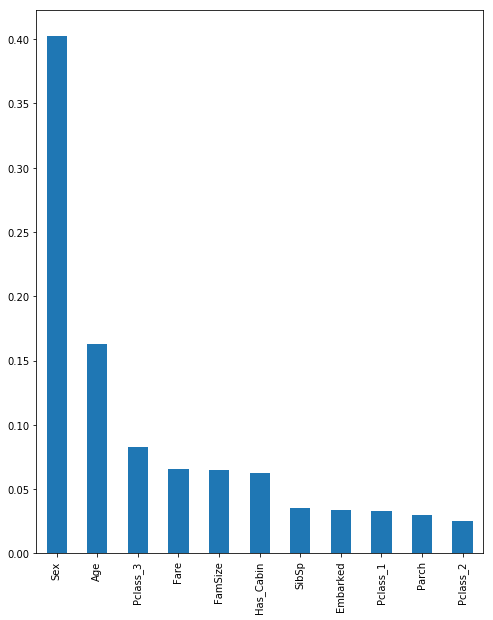

In [66]:
pd.Series([x[1] for x in feature_imp], index=[x[0] for x in feature_imp]).plot(kind='bar')

The last thing I have to do is export a cvs of each prediction and pray that one of them works.

In [67]:
# Export predictions to Kaggle

# Change working directory for exporting csv files
os.chdir("/Users/jperryman/Desktop/BYU/Python/HW3")
test_submission = pd.read_csv(test_location)

# List of models used
models = [lr, knn, nb, svm, dt]#, rf]
model_names = ["lr", "knn", "nb", "svm", "dt"]#, "rf"]

# Iterate over each model, creating list of predictions and then export has csv
for i in range(0, len(models)):
    model = models[i]
    y_pred = model.predict(scaled_test)
    pred = pd.DataFrame({'PassengerId': list(test_submission['PassengerId'].astype(int)), 'Survived': list(y_pred)})
    filename = ('submission_{}.csv'.format(model_names[i]))
    pred.to_csv(filename, sep=',', index = False)

I hope you enjoyed this workbook.  So far this notebook is ranked #2209 at .79425